# Question 4

Improved SVM sentiment classification using sentiment-dataset.tsv dataset.

In [ ]:
import re
import csv  # csv reader
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.classify import SklearnClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    precision_recall_fscore_support,
)  # to report on precision and recall
import numpy as np

In [177]:
# initialize global variables
raw_data = []             # the filtered data from the dataset file
train_data = []           # the pre-processed training data as a percentage of the total dataset
test_data = []            # the pre-processed test data as a percentage of the total dataset
global_feature_dict = {}  # the dictionary of features

In [178]:
def parse_data_line(data_line):
    """Return a tuple of the label as just FAKE or REAL and the statement"""
    return (data_line[1], data_line[2])


lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# Load positive and negative word lists from text files
positive_words = set()
negative_words = set()

with open("positive-words.txt", "r", encoding="latin-1") as f:
    for line in f:
        word = line.strip()
        if word:
            positive_words.add(word)

with open("negative-words.txt", "r", encoding="latin-1") as f:
    for line in f:
        word = line.strip()
        if word:
            negative_words.add(word)

# def get_wordnet_pos(tag):
#     """Map POS tag to WordNet POS tag."""
#     if tag.startswith("J"):
#         return wordnet.ADJ
#     elif tag.startswith("V"):
#         return wordnet.VERB
#     elif tag.startswith("N"):
#         return wordnet.NOUN
#     elif tag.startswith("R"):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN

# CONTRACTIONS = {
# "c'mon": "come on",
# "now's": "now is",
# "he's": "he is",
# "she's": "she is",
# "what's": "what is",
# "haven't": "have not",
# "didn't": "did not",
# "don't": "do not",
# "doesn't": "does not",
# "isn't": "is not",
# "it's": "it is",
# "i'm": "i am",
# "i'll": "i will",
# "we're": "we are",
# "there's": "there is",
# "they'll": "they will",
# "would've": "would have",
# "you've": "you have",
# }

# def expand_contractions(text):
#     pattern = re.compile(r'\b(' + '|'.join(CONTRACTIONS.keys()) + r')\b')
#     return pattern.sub(lambda x: CONTRACTIONS[x.group()], text)


def pre_process(text):
    # Normalize
    text = text.lower()
    # text = expand_contractions(text)

    # Remove URLs, mentions, punctuation
    # text = re.sub(r"[?!:;.]", "", text)
    # text = re.sub(r"[-,#]", " ", text)
    # text = re.sub(r'https?://(www\.)?([A-Za-z0-9\-\.]+)\S*', r'<url> \2', text)
    # text = re.sub(r"https?://\S+|www\.\S+", "<url>", text)     # Replace URLs
    # text = re.sub(r"@\w+", "<user>", text)                     # Replace mentions
    # text = re.sub(r"@(\w+)", r"<user> \1", text)               # Extract user mentions

    # text = re.sub(r"#(\w+)", r"<hashtag> \1", text)  # Extract hashtags
    # text = re.sub(r"[!?]+", " <emph> ", text)        # Mark emphasis
    text = re.sub(r"[-.,]", " ", text)                 # Clean up minor punctuation
    text = re.sub(r"([a-z])\1{2,}", r"\1\1", text)     # Reduce elongated words
    text = re.sub(r"\s{2,}", " ", text).strip()        # Normalize spaces

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Stop word removal
    stop_words = {"the", "to", "a", "of", "and", "i"}
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatization with POS tagging
    # pos_tags = nltk.pos_tag(tokens)
    # lemmas = [
    #     lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags
    # ]

    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmas


def to_feature_vector(tokens):
    """Convert a list of tokens into a feature vector including unigrams and bigrams."""
    feature_vector = {}

    # POS Tag features
    # pos_tags = nltk.pos_tag(tokens)
    # for token, pos in pos_tags:
    #     pos_feature = f"pos:{pos}"
    #     if pos_feature not in global_feature_dict:
    #         global_feature_dict[pos_feature] = len(global_feature_dict)
    #     idx_pos = global_feature_dict[pos_feature]
    #     feature_vector[idx_pos] = feature_vector.get(idx_pos, 0) + 1

    # Unigrams
    for token in tokens:
        word_feature = f"word:{token}"
        if word_feature not in global_feature_dict:
            global_feature_dict[word_feature] = len(global_feature_dict)
        idx_word = global_feature_dict[word_feature]
        feature_vector[idx_word] = feature_vector.get(idx_word, 0) + 1

    # Bigrams
    for i in range(len(tokens) - 1):
        bigram_feature = f"bigram:{tokens[i]}_{tokens[i + 1]}"
        if bigram_feature not in global_feature_dict:
            global_feature_dict[bigram_feature] = len(global_feature_dict)
        idx_bigram = global_feature_dict[bigram_feature]
        feature_vector[idx_bigram] = feature_vector.get(idx_bigram, 0) + 1

    # Trigrams
    # for i in range(len(tokens) - 2):
    #     feature = f"trigram:{tokens[i]}_{tokens[i+1]}_{tokens[i+2]}"
    #     if feature not in global_feature_dict:
    #         global_feature_dict[feature] = len(global_feature_dict)
    #     idx = global_feature_dict[feature]
    #     feature_vector[idx] = feature_vector.get(idx, 0) + 1

    # Length feature
    num_words = len(tokens)

    # Opinion Lexicon features
    pos_count = sum(1 for t in tokens if t in positive_words)
    neg_count = sum(1 for t in tokens if t in negative_words)
    sentiment_ratio = (pos_count - neg_count) / (pos_count + neg_count + 1e-5)

    vader_scores = sia.polarity_scores(" ".join(tokens))
    vader_pos = vader_scores["pos"]
    vader_neg = vader_scores["neg"]
    vader_comp = vader_scores["compound"]

    for feat_name, value in [
        ("positive_count", pos_count),
        ("negative_count", neg_count),
        ("sentiment_ratio", sentiment_ratio),
        ("num_words", num_words),
        ("vader_pos", vader_pos),
        ("vader_neg", vader_neg),
        ("vader_compound", vader_comp),
    ]:
        if feat_name not in global_feature_dict:
            global_feature_dict[feat_name] = len(global_feature_dict)
        idx = global_feature_dict[feat_name]
        feature_vector[idx] = value

    return feature_vector


In [179]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter="\t")
        for line in reader:
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))


def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for text, label in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)), label))
    for text, label in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)), label))

In [180]:
# references to the data files
data_file_path = "sentiment-dataset.tsv"

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print(
    f"Now {len(raw_data)} rawData, {len(train_data)} trainData, {len(test_data)} testData",
    "Preparing the dataset...",
    sep="\n",
)

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print(
    f"Now {len(raw_data)} rawData, {len(train_data)} trainData, {len(test_data)} testData",
    "Preparing training and test data...",
    sep="\n",
)

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print(
    f"After split, {len(raw_data)} rawData, {len(train_data)} trainData, {len(test_data)} testData",
    f"Training Samples: {len(train_data)}",
    f"Features: {len(global_feature_dict)}",
    sep="\n",
)


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 26832
Features: 379088


In [189]:
def train_classifier(data):
    pipeline = Pipeline([("svc", LinearSVC(C=1.1, class_weight="balanced", max_iter=9000))])
    return SklearnClassifier(pipeline).train(data)


def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)


def cross_validate(dataset, folds):
    cv_results = {"precision": [], "recall": [], "f1-score": [], "accuracy": []}
    fold_size = int(len(dataset) / folds) + 1

    for i in range(0, len(dataset), int(fold_size)):
        train_set = dataset[:i] + dataset[i + fold_size :]
        test_set = dataset[i : i + fold_size]
        test_features, test_labels = zip(*test_set)

        classifier = train_classifier(train_set)
        predictions = predict_labels(test_features, classifier)

        report = classification_report(test_labels, predictions, output_dict=True)
        cv_results["precision"].append(report["weighted avg"]["precision"])
        cv_results["recall"].append(report["weighted avg"]["recall"])
        cv_results["f1-score"].append(report["weighted avg"]["f1-score"])
        cv_results["accuracy"].append(report["accuracy"])

    cv_results = {k: np.mean(v) for k, v in cv_results.items()}
    return cv_results

In [190]:
cross_validate(train_data, 10)

/home/nick/src/ECS763/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'precision': np.float64(0.8873397197778381),
 'recall': np.float64(0.8879704566060516),
 'f1-score': np.float64(0.8874268579427991),
 'accuracy': np.float64(0.8879704566060516)}

{'negative': {'precision': 0.85359477124183, 'recall': 0.7982885085574573, 'f1-score': 0.8250157927984839, 'support': 818.0}, 'positive': {'precision': 0.9140177175612298, 'recall': 0.939978563772776, 'f1-score': 0.9268163804491414, 'support': 1866.0}, 'accuracy': 0.896795827123696, 'macro avg': {'precision': 0.88380624440153, 'recall': 0.8691335361651167, 'f1-score': 0.8759160866238127, 'support': 2684.0}, 'weighted avg': {'precision': 0.8956026765443637, 'recall': 0.896795827123696, 'f1-score': 0.8957907169997235, 'support': 2684.0}}
Sum of Errors [('positive_count', 277), ('negative_count', 277), ('sentiment_ratio', 277), ('num_words', 277), ('vader_pos', 277)]


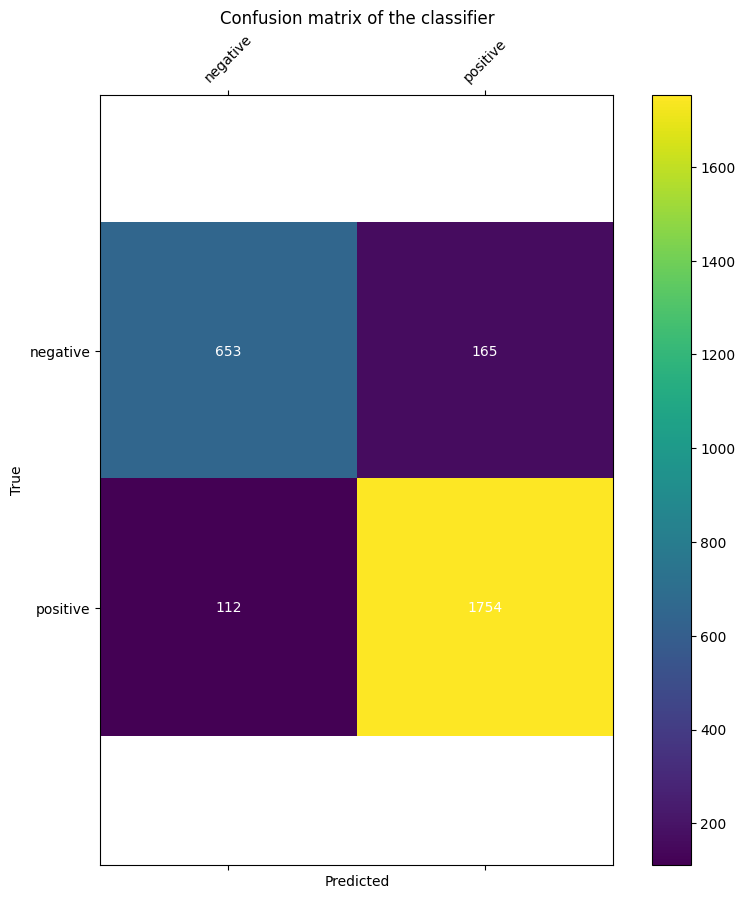

In [183]:
from sklearn import metrics
import matplotlib.pyplot as plt


# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title("Confusion matrix of the classifier")
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")

    plt.xlabel("Predicted")
    plt.ylabel("True")

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    plt.ylim(b, t)  # update the ylim(bottom, top) values
    plt.show()  # ta-da!
    plt.show()


fold_size = int(len(train_data) / 10) + 1
train_set = train_data[fold_size:]
test_set = train_data[:fold_size]
test_features, test_labels = zip(*test_set)

training_samples = int((0.8 * len(raw_data)))
raw_test_set = raw_data[:training_samples]
raw_test_set = raw_test_set[fold_size:]

classifier = train_classifier(train_set)
predictions = predict_labels(test_features, classifier)
report = classification_report(test_labels, predictions, output_dict=True)
print(report)

index_to_feature = {v: k for k, v in global_feature_dict.items()}
false_positive_features = {}
false_negative_features = {}
false_features = {}
false_positive_results = []
false_negative_results = []

for idx, value in enumerate(test_features):
    if test_labels[idx] == "negative" and predictions[idx] == "positive":
        for feature_idx, count in value.items():
            feature = index_to_feature.get(feature_idx)
            false_positive_features[feature] = (
                false_positive_features.get(feature, 0) + 1
            )
        false_positive_results.append(f"{raw_test_set[idx][1]} {raw_test_set[idx][0]}")

    if test_labels[idx] == "positive" and predictions[idx] == "negative":
        for feature_idx, count in value.items():
            feature = index_to_feature.get(feature_idx)
            false_negative_features[feature] = (
                false_negative_features.get(feature, 0) + 1
            )
        false_negative_results.append(f"{raw_test_set[idx][1]} {raw_test_set[idx][0]}")

    if test_labels[idx] != predictions[idx]:
        for feature_idx, count in value.items():
            feature = index_to_feature.get(feature_idx)
            false_features[feature] = false_features.get(feature, 0) + 1

sorted_fp = sorted(false_positive_features.items(), key=lambda x: x[1], reverse=True)
sorted_fn = sorted(false_negative_features.items(), key=lambda x: x[1], reverse=True)
sorted_f = sorted(false_features.items(), key=lambda x: x[1], reverse=True)

print(f"Sum of Errors {sorted_f[:5]}")
with open("false_positives.txt", "w") as f:
    f.write(f"False Positives {sorted_fp[:5]}\n\n")
    f.write("\n".join(false_positive_results))

with open("false_negatives.txt", "w") as f:
    f.write(f"False Negatives {sorted_fn[:5]}\n\n")
    f.write("\n".join(false_negative_results))

with open("global_feature_dict.txt", "w") as f:
    for item in global_feature_dict.items():
        f.write(f"{item}\n")

confusion_matrix_heatmap(test_labels, predictions, labels=["negative", "positive"])

In [184]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({191: 1, 484: 2, 1912: 2, 2850: 1, 100: 2, 157462: 1, 182: 1, 154: 1, 317834: 1, 317835: 1, 633: 1, 2625: 1, 26: 1, 317836: 1, 189: 2, 365: 1, 292: 1, 95486: 1, 8905: 1, 3985: 1, 18429: 2, 317837: 1, 106680: 1, 317838: 1, 317839: 1, 57376: 1, 317840: 1, 317841: 1, 317842: 1, 2637: 1, 2638: 1, 2639: 1, 317843: 1, 317844: 1, 939: 1, 98612: 1, 17405: 1, 131621: 1, 317845: 1, 225495: 1, 19: 0, 20: 0, 21: 0.0, 22: 23, 23: 0.0, 24: 0.0, 25: 0.0}, 'positive')
Done training!
Precision: 0.887124
Recall: 0.887746
F Score:0.887327
